# Import packages

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys

# sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('../../utils/')
from annotations_utils import *
import scvi
print(scvi.__version__)

import os
os.getcwd()

import logging
import pickle
from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

from scvi.dataset.anndataset import AnnDatasetFromAnnData

import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

n_epochs = 150
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=True


sc.logging.print_versions()

[2020-02-24 12:54:09,265] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/angela/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.5.0
scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Load data

In [3]:
data_path = '../../data-objs/pilot1/FinalAnnotation/'

In [7]:
import os
os.listdir(data_path)

In [8]:
adata = read_h5ad(data_path+'CombineCompartments.scANVI.all.h5ad')
adata

AnnData object with n_obs × n_vars = 68451 × 21301 
    obs: 'Tissue Tech', '10X_plate', 'Manual Annotation Round 2', 'scANVI Prediction By Organ', 'n_genes', 'tissue', 'leiden_scvi', 'leiden_scvi_split', 'Compartment', 'scANVI Prediction By Organ-Compartment', 'scANVI Prediction By Organ with Alternate Training', 'scANVI Prediction By Organ-Compartment with Alternate Training', 'batch_id', 'S_score', 'G2M_score', 'phase', 'scANVI Prediction Ontology Term By Organ', 'scANVI Prediction Ontology Term By Organ with Alternate Training', 'scANVI Prediction Ontology Term By Organ-Compartment', 'scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training', 'Manual Annotation Round 2 Ontology Terms', 'log1p_total_counts'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [9]:
adata.obs.head()

,Tissue Tech,10X_plate,Manual Annotation Round 2,scANVI Prediction By Organ,n_genes,tissue,leiden_scvi,leiden_scvi_split,Compartment,scANVI Prediction By Organ-Compartment,...,batch_id,S_score,G2M_score,phase,scANVI Prediction Ontology Term By Organ,scANVI Prediction Ontology Term By Organ with Alternate Training,scANVI Prediction Ontology Term By Organ-Compartment,scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training,Manual Annotation Round 2 Ontology Terms,log1p_total_counts
index,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGCATCCCG-1-0,endopancreas_10x,1,unassigned,pancreatic ductal cell,500,Pancreas,4,6,Epithelial,pancreatic ductal cell,...,8,0.001789,-0.030600,S,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,cell,6.467699
AAAGGATTCTCGCCTA-1-0,endopancreas_10x,1,unassigned,pancreatic acinar cell,384,Pancreas,0,2,mixed,pancreatic acinar cell,...,8,0.012151,-0.150551,S,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,cell,7.651596
AAAGGGCGTGGGCTCT-1-0,endopancreas_10x,1,pancreatic acinar cell,pancreatic acinar cell,215,Pancreas,2,0,Stromal,pancreatic acinar cell,...,8,-0.009067,-0.154223,G1,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,7.617760
AACAAAGTCGAAGCCC-1-0,endopancreas_10x,1,pancreatic acinar cell,pancreatic acinar cell,343,Pancreas,4,3,Epithelial,pancreatic acinar cell,...,8,-0.009067,-0.035337,G1,pancreatic acinar cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic ductal cell,pancreatic acinar cell,6.666957
AACAACCTCAACGAGG-1-0,endopancreas_10x,1,endothelial cell,endothelial cell,1590,Pancreas,7,7,mixed,endothelial cell,...,8,-0.002406,-0.102339,G1,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,8.036250


In [10]:
adata.obs['tissue'] = adata.obs['tissue'].str.lower()
adata.obs['subtissue'] = adata.obs['tissue']
adata.obs.loc[adata.obs['tissue'].isin(
    ['exopancreas1','endopancreas','exopancreas2','pancreasendocrine', 'pancreasexocrine']),'tissue'] = 'pancreas'

adata.obs['method'] = [tt.split('_')[1] for tt in adata.obs['Tissue Tech']]

# adata.obs = adata.obs.drop(
#     ['Compartment Prediction', '10X_plate','Compartment', 'S_score', 'G2M_score', 'phase'],
#     axis=1)

adata.obs = adata.obs.rename(columns={"Tissue Tech": "tissue_method",
                                      "Pancreas Prediction" : "pancreas_prediction",
                                     "Manual Annotation Round 2": "manual_free_annotation",
                                     "Manual Annotation Round 2 Ontology Terms": "manual_cell_ontology",
                                     "Smoothed Compartment Prediction": "compartment_prediction",
                                     "scANVI Prediction By Organ": "scANVI_organ_free_annotation",
                                     "scANVI Prediction By Organ-Compartment": "scANVI_organ_compartment_free_annotation",
                                     "scANVI Prediction By Organ with Alternate Training": "scANVI_organ_alternate_training_free_annotation",
                                     "scANVI Prediction By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_free_annotation",
                                     "scANVI Prediction Ontology Term By Organ": "scANVI_organ_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment": "scANVI_organ_compartment_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ with Alternate Training": "scANVI_organ_alternate_training_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_cell_ontology"})

# adata.obs['compartment_prediction'] = adata.obs['compartment_prediction'].str.lower()

adata.obs = adata.obs.reindex(sorted(adata.obs.columns), axis=1)

adata

AnnData object with n_obs × n_vars = 68451 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [11]:
adata.obs['method'].head()

index
AAACGAAAGCATCCCG-1-0    10x
AAAGGATTCTCGCCTA-1-0    10x
AAAGGGCGTGGGCTCT-1-0    10x
AACAAAGTCGAAGCCC-1-0    10x
AACAACCTCAACGAGG-1-0    10x
Name: method, dtype: object

In [12]:
adata10X = adata[adata.obs['method']=='10x'].copy()
adata10X

AnnData object with n_obs × n_vars = 64367 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [13]:
adata10X.X[1000:2000,1000:2000].todense()

matrix([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
sc.pp.filter_cells(adata10X,min_counts=0)
sc.pp.filter_cells(adata10X,min_genes=0)
adata10X

AnnData object with n_obs × n_vars = 64367 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method', 'n_counts'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

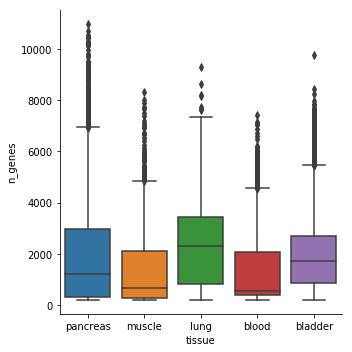

In [16]:
sns.catplot(data = adata10X.obs, x = 'tissue', y='n_genes',kind='box')

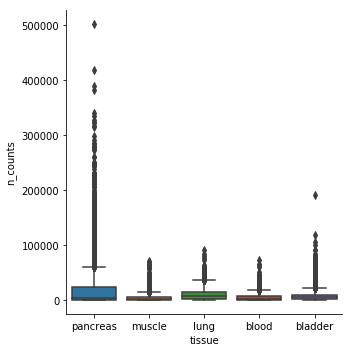

In [18]:
sns.catplot(data = adata10X.obs, x = 'tissue', y='n_counts',kind='box')